Baseline LSTM -> RMSE: 0.18861476989645293 MAE: 0.15113739669322968
Attention LSTM -> RMSE: 0.2005056441528151 MAE: 0.1594320833683014


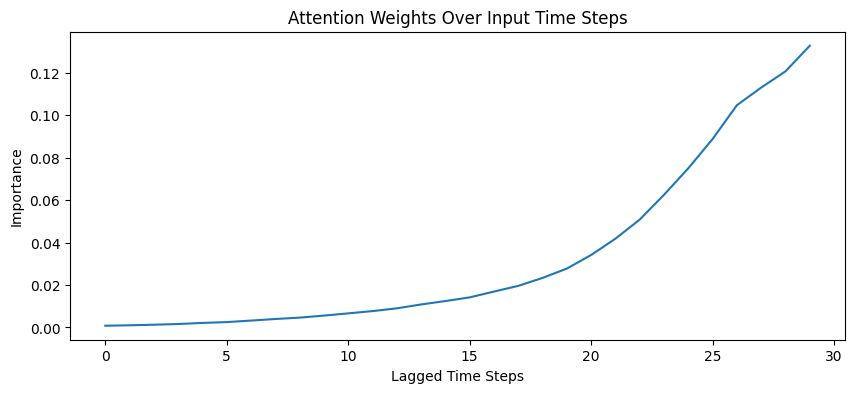

In [3]:
# ==============================
# Advanced Time Series Forecasting with Attention-Based LSTM + Explainability
# ==============================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import random

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1. Synthetic Non-Stationary Multivariate Dataset
# ------------------------------
def generate_time_series(n_steps=1200):
    t = np.arange(n_steps)
    trend = 0.005 * t
    seasonality = np.sin(0.02 * t) + 0.5 * np.sin(0.05 * t)
    noise = np.random.normal(0, 0.3, n_steps)

    series_1 = trend + seasonality + noise
    series_2 = np.roll(series_1, 3) * 0.7 + np.random.normal(0, 0.2, n_steps)
    series_3 = np.cos(0.015 * t) + np.random.normal(0, 0.25, n_steps)

    return np.vstack([series_1, series_2, series_3]).T

data = generate_time_series()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ------------------------------
# 2. Dataset & DataLoader
# ------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=30, horizon=5):
        self.X, self.y = [], []
        for i in range(len(data) - seq_len - horizon):
            self.X.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len:i+seq_len+horizon, 0])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

SEQ_LEN = 30
HORIZON = 5

dataset = TimeSeriesDataset(data_scaled, SEQ_LEN, HORIZON)
train_size = int(0.8 * len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# ------------------------------
# 3. Baseline LSTM (No Attention)
# ------------------------------
class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ------------------------------
# 4. Explicit Attention Mechanism
# ------------------------------
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_outputs):
        scores = self.attn(lstm_outputs).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(lstm_outputs * weights.unsqueeze(-1), dim=1)
        return context, weights

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, horizon)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        output = self.fc(context)
        return output, attn_weights

# ------------------------------
# 5. Training & Evaluation
# ------------------------------
def train_model(model, loader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        model.train()
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X) if isinstance(model, BaselineLSTM) else model(X)[0]
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

def evaluate_model(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            output = model(X) if isinstance(model, BaselineLSTM) else model(X)[0]
            preds.append(output.cpu().numpy())
            targets.append(y.numpy())
    preds = np.vstack(preds)
    targets = np.vstack(targets)
    return (
        np.sqrt(mean_squared_error(targets, preds)), # Modified: Removed squared=False and added np.sqrt
        mean_absolute_error(targets, preds)
    )

# ------------------------------
# 6. Train Models
# ------------------------------
baseline = BaselineLSTM(3, 64, HORIZON)
attn_model = AttentionLSTM(3, 64, HORIZON)

train_model(baseline, train_loader)
train_model(attn_model, train_loader)

baseline_rmse, baseline_mae = evaluate_model(baseline, test_loader)
attn_rmse, attn_mae = evaluate_model(attn_model, test_loader)

print("Baseline LSTM -> RMSE:", baseline_rmse, "MAE:", baseline_mae)
print("Attention LSTM -> RMSE:", attn_rmse, "MAE:", attn_mae)

# ------------------------------
# 7. Explainability: Attention Weights Analysis
# ------------------------------
X_sample, y_sample = next(iter(test_loader))
X_sample = X_sample.to(device)

_, attention_weights = attn_model(X_sample)
attention_weights = attention_weights.detach().cpu().numpy() # Added .detach()

plt.figure(figsize=(10,4))
plt.plot(attention_weights[0])
plt.title("Attention Weights Over Input Time Steps")
plt.xlabel("Lagged Time Steps")
plt.ylabel("Importance")
plt.show()